In [1]:
301.!pip install split-folders

In [9]:
#Importing Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import cv2
import os
import PIL
import pathlib
import splitfolders

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

In [5]:
from google.colab import drive       #to read the dataset from drive libraries is imported


In [6]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [10]:
base_ds = '/content/gdrive/MyDrive/Rice_Image_Dataset'
base_ds = pathlib.Path(base_ds)

In [11]:
!nvidia-smi

Mon May  2 16:21:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [12]:
splitfolders.ratio(base_ds, output='imgs', seed=123, ratio=(.7,.15,.15), group_prefix=None)

Copying files: 74841 files [19:38, 63.51 files/s] 


In [13]:
arborio = [fn for fn in os.listdir(f'{base_ds}/Arborio') if fn.endswith('.jpg')]
bastmati = [fn for fn in os.listdir(f'{base_ds}/Basmati') if fn.endswith('.jpg')]
ipsala = [fn for fn in os.listdir(f'{base_ds}/Ipsala') if fn.endswith('.jpg')]
jasmine = [fn for fn in os.listdir(f'{base_ds}/Jasmine') if fn.endswith('.jpg')]
karacadag = [fn for fn in os.listdir(f'{base_ds}/Karacadag') if fn.endswith('.jpg')]
rice = [arborio, bastmati, ipsala, jasmine, karacadag]
rice_classes = []
for i in os.listdir('imgs/train'):
    rice_classes+=[i]
rice_classes.sort()

# **Data Analysis and Visualization**

Total images: 74841
Total number of classes: 5
Total Arborio images: 15000
Total Basmati images: 15010
Total Ipsala images: 15000
Total Jasmine images: 15000
Total Karacadag images: 14831


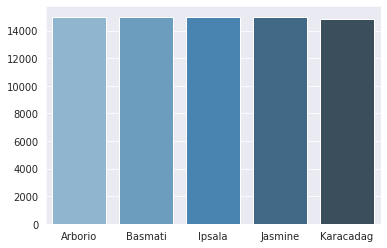

In [14]:
image_count = len(list(base_ds.glob('*/*.jpg')))
print(f'Total images: {image_count}')
print(f'Total number of classes: {len(rice_classes)}')
count = 0
rice_count = []
for x in rice_classes:
  print(f'Total {x} images: {len(rice[count])}')
  rice_count.append(len(rice[count]))
  count += 1

sns.set_style('darkgrid')
sns.barplot(x=rice_classes, y=rice_count, palette="Blues_d")
plt.show()

Image dimensions: (250, 250, 3)


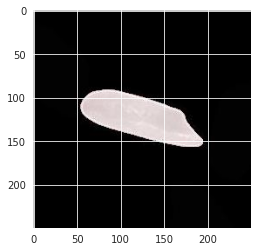

In [15]:
sample_img = cv2.imread('imgs/test/Jasmine/Jasmine (10).jpg')
plt.imshow(sample_img)
print(f'Image dimensions: {sample_img.shape}')

In [16]:
def load_random_img(dir, label):
  plt.figure(figsize=(10,10))
  i=0
  for label in rice_classes:
    i+=1
    plt.subplot(1, 5, i)
    file = random.choice(os.listdir(f'{dir}/{label}'))
    image_path = os.path.join(f'{dir}/{label}', file)
    img=cv2.imread(image_path)
    plt.title(label)
    plt.imshow(img)
    plt.grid(None)
    plt.axis('off')

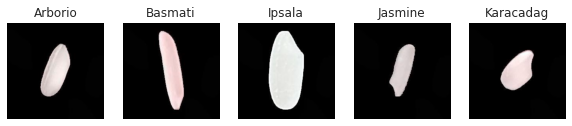

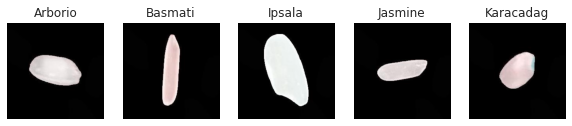

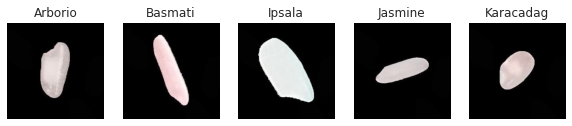

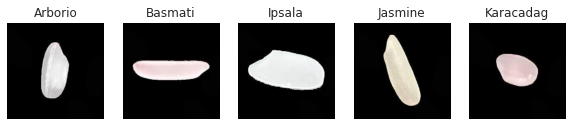

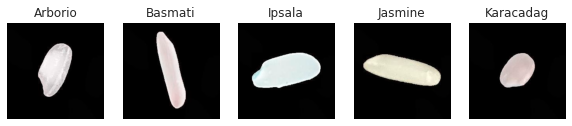

In [17]:
for i in range(5):
  load_random_img(base_ds, rice_classes)

In [18]:
batch_size = 128
img_height, img_width = 175, 175
input_shape = (img_height, img_width, 3)

**Data Pre-Processing**

In [19]:
datagen = ImageDataGenerator(rescale=1./255)

In [20]:
train_ds = datagen.flow_from_directory(
    'imgs/train',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    subset = "training",
    class_mode='categorical')

val_ds = datagen.flow_from_directory(
    'imgs/val',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

test_ds = datagen.flow_from_directory(
    'imgs/test',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

Found 52388 images belonging to 5 classes.
Found 11225 images belonging to 5 classes.
Found 11228 images belonging to 5 classes.


In [21]:
def plot_train_history(history):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

# **Building Model**

In [22]:
model_vanilla = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(3,3), activation='relu', input_shape=input_shape),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(axis = 3),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(axis = 3),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(axis = 3),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(5, activation='softmax')
])

# **Model Training**

In [56]:
models_dir = "saved_models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

checkpointer = ModelCheckpoint(filepath='saved_models/model_vanilla.hdf5', 
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.001)
callbacks=[early_stopping, reduce_lr, checkpointer]

In [59]:
model_vanilla.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [25]:
history1 = model_vanilla.fit(train_ds, epochs = 10, validation_data = val_ds, callbacks=callbacks)

Epoch 1/10
410/410 [==============================] - ETA: 0s - loss: 0.1010 - accuracy: 0.9663
Epoch 1: val_accuracy improved from -inf to 0.19492, saving model to saved_models/model_vanilla.hdf5
410/410 [==============================] - 211s 474ms/step - loss: 0.1010 - accuracy: 0.9663 - val_loss: 36.3736 - val_accuracy: 0.1949 - lr: 0.0010
Epoch 2/10
410/410 [==============================] - ETA: 0s - loss: 0.0372 - accuracy: 0.9880
Epoch 2: val_accuracy improved from 0.19492 to 0.96116, saving model to saved_models/model_vanilla.hdf5
410/410 [==============================] - 196s 478ms/step - loss: 0.0372 - accuracy: 0.9880 - val_loss: 0.1942 - val_accuracy: 0.9612 - lr: 0.0010
Epoch 3/10
410/410 [==============================] - ETA: 0s - loss: 0.0290 - accuracy: 0.9903
Epoch 3: val_accuracy did not improve from 0.96116
410/410 [==============================] - 196s 478ms/step - loss: 0.0290 - accuracy: 0.9903 - val_loss: 0.7620 - val_accuracy: 0.9042 - lr: 0.0010
Epoch 4/10


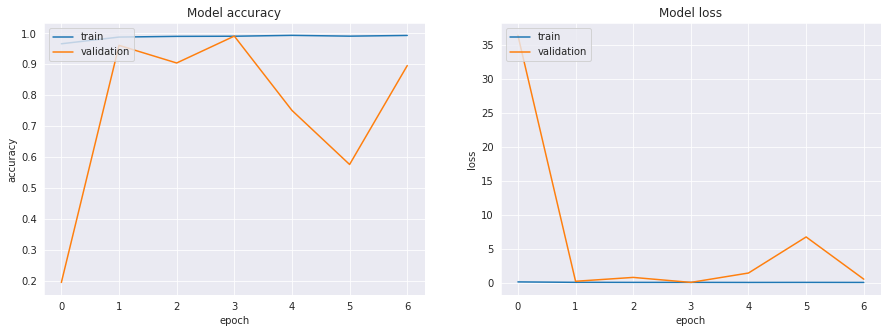

In [26]:
model_vanilla.load_weights('saved_models/model_vanilla.hdf5')
plot_train_history(history1)

**Model Evaluation of vanilla CNN**

In [27]:
score1 = model_vanilla.evaluate(test_ds, verbose=1)

88/88 [==============================] - 21s 232ms/step - loss: 0.5221 - accuracy: 0.8892


In [31]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model_vanilla.predict(test_ds)


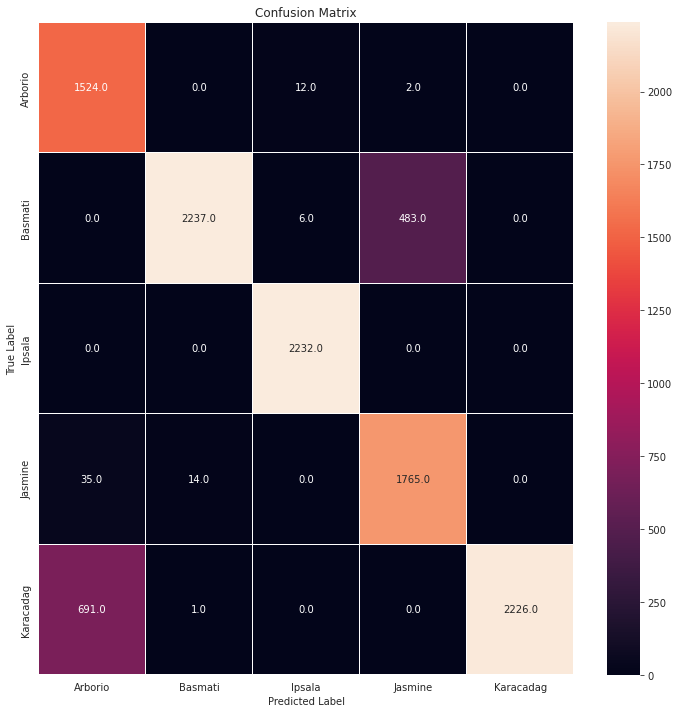

In [32]:
y_pred = np.argmax(Y_pred, axis=1)
confusion_mtx = confusion_matrix(y_pred, test_ds.classes)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_ds.class_indices)
ax.yaxis.set_ticklabels(rice_classes)
plt.title("Confusion Matrix")
plt.show()

In [34]:
report1 = classification_report(test_ds.classes, y_pred, target_names=rice_classes, output_dict=True)


In [35]:
df1 = pd.DataFrame(report1).transpose()
df1

,precision,recall,f1-score,support
Arborio,0.990897,0.677333,0.804646,2250.000000
Basmati,0.820616,0.993339,0.898755,2252.000000
Ipsala,1.000000,0.992000,0.995984,2250.000000
Jasmine,0.972988,0.784444,0.868602,2250.000000
Karacadag,0.762851,1.000000,0.865474,2226.000000
accuracy,0.889206,0.889206,0.889206,0.889206
macro avg,0.909471,0.889423,0.886692,11228.000000
weighted avg,0.909768,0.889206,0.886740,11228.000000


**Transfer Learning**

In [36]:
vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
vgg16.trainable = False
inputs = tf.keras.Input(input_shape)
x = vgg16(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(5, activation='softmax')(x)
model_vgg16 = tf.keras.Model(inputs, x)

58900480/58889256 [==============================] - 2s 0us/step


In [57]:
model_vgg16.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 175, 175, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_3 (Dense)             (None, 1024)              525312    
                                                                 
 dense_4 (Dense)             (None, 5)                 5125      
                                                                 
Total params: 15,245,125
Trainable params: 530,437
Non-trainable params: 14,714,688
___________________________________________

**Transfer Learning**

**Model Traning for vgg16**

In [38]:
checkpointer = ModelCheckpoint(filepath='saved_models/model_vgg16.hdf5', 
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.001)
callbacks=[early_stopping, reduce_lr, checkpointer]

In [60]:
model_vgg16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [40]:
history2 = model_vgg16.fit(train_ds, epochs =10, validation_data = val_ds, callbacks=callbacks)

Epoch 1/10
410/410 [==============================] - ETA: 0s - loss: 0.1368 - accuracy: 0.9667
Epoch 1: val_accuracy improved from -inf to 0.98370, saving model to saved_models/model_vgg16.hdf5
410/410 [==============================] - 205s 501ms/step - loss: 0.1368 - accuracy: 0.9667 - val_loss: 0.0560 - val_accuracy: 0.9837 - lr: 0.0010
Epoch 2/10
410/410 [==============================] - ETA: 0s - loss: 0.0460 - accuracy: 0.9857
Epoch 2: val_accuracy improved from 0.98370 to 0.98993, saving model to saved_models/model_vgg16.hdf5
410/410 [==============================] - 209s 510ms/step - loss: 0.0460 - accuracy: 0.9857 - val_loss: 0.0350 - val_accuracy: 0.9899 - lr: 0.0010
Epoch 3/10
410/410 [==============================] - ETA: 0s - loss: 0.0331 - accuracy: 0.9898
Epoch 3: val_accuracy did not improve from 0.98993
410/410 [==============================] - 209s 510ms/step - loss: 0.0331 - accuracy: 0.9898 - val_loss: 0.0349 - val_accuracy: 0.9887 - lr: 0.0010
Epoch 4/10
410/4

In [41]:
model_vgg16.load_weights('saved_models/model_vgg16.hdf5')

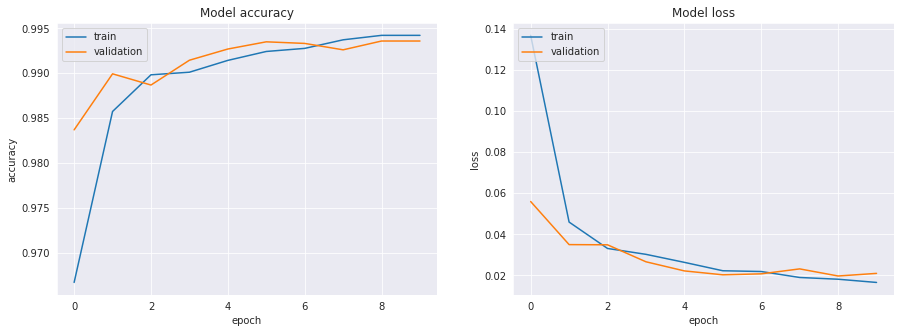

In [42]:
plot_train_history(history2)

**Final Evaluation**

In [43]:
score2 = model_vgg16.evaluate(test_ds, verbose=1)
print(f'Model 1 Vanilla Loss: {score1[0]}, Accuracy: {score1[1]*100}')
print(f'Model 2 VGG16 Loss: {score2[0]}, Accuracy: {score2[1]*100}')

88/88 [==============================] - 39s 441ms/step - loss: 0.0174 - accuracy: 0.9951
Model 1 Vanilla Loss: 0.5220906138420105, Accuracy: 88.92055749893188
Model 2 VGG16 Loss: 0.017387181520462036, Accuracy: 99.51015114784241


In [44]:
Y_pred = model_vgg16.predict(test_ds)

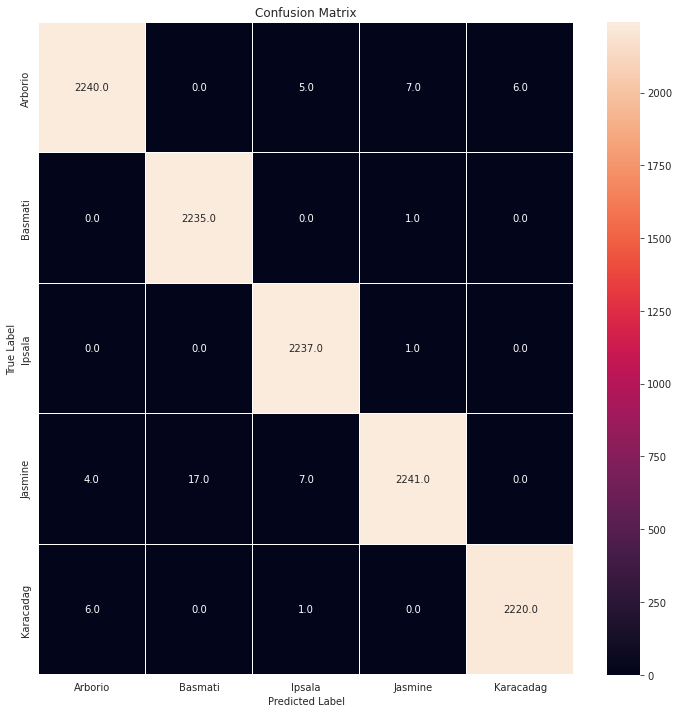

In [45]:
y_pred = np.argmax(Y_pred, axis=1)
confusion_mtx = confusion_matrix(y_pred, test_ds.classes)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_ds.class_indices)
ax.yaxis.set_ticklabels(rice_classes)
plt.title("Confusion Matrix")
plt.show()

In [46]:
report2 = classification_report(test_ds.classes, y_pred, target_names=rice_classes, output_dict=True)

In [47]:
df2 = pd.DataFrame(report1).transpose()
df2

,precision,recall,f1-score,support
Arborio,0.990897,0.677333,0.804646,2250.000000
Basmati,0.820616,0.993339,0.898755,2252.000000
Ipsala,1.000000,0.992000,0.995984,2250.000000
Jasmine,0.972988,0.784444,0.868602,2250.000000
Karacadag,0.762851,1.000000,0.865474,2226.000000
accuracy,0.889206,0.889206,0.889206,0.889206
macro avg,0.909471,0.889423,0.886692,11228.000000
weighted avg,0.909768,0.889206,0.886740,11228.000000


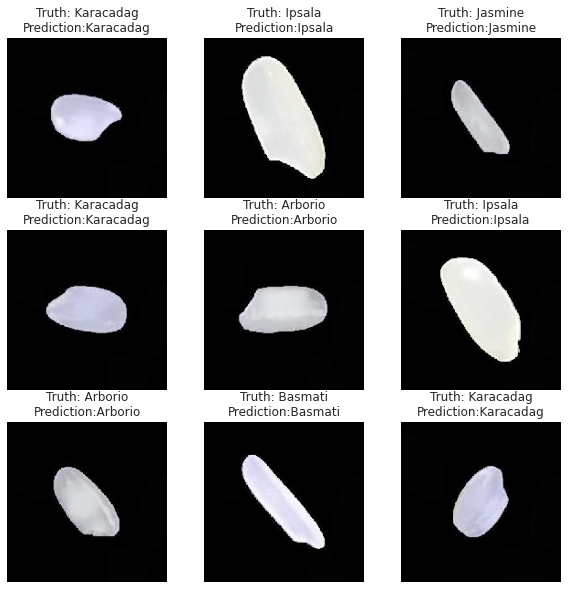

In [53]:
plt.figure(figsize=(10, 10))
x, label= train_ds.next()
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x[i])
    result = np.where(label[i]==1)
    predict = model_vgg16(tf.expand_dims(x[i], 0))
    score = tf.nn.softmax(predict[0])
    score_label = rice_classes[np.argmax(score)]
    plt.title(f'Truth: {rice_classes[result[0][0]]}\nPrediction:{score_label}')
    plt.axis(False)